# 0 라이브러리 임포트 

In [31]:
# 필요한 라이브러리를 임포트합니다.
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import numpy as np  # 수치 계산을 위한 라이브러리
import wfdb  # 심전도 데이터를 읽기 위한 라이브러리
import ast  # 문자열 형태의 파이썬 표현식을 파싱하기 위한 라이브러리
from tqdm import tqdm  # 반복 작업의 진행 상황을 시각적으로 표시하기 위한 라이브러리
import warnings; warnings.filterwarnings('ignore')  # 경고 메시지를 무시하기 위한 설정
from IPython.display import display  # Jupyter 노트북에서 데이터를 깔끔하게 보여주기 위한 함수
from glob import glob # 하위 디렉토리에 파일을 가져와서 다루기위한 라이브러리 
import os # 현재 워킹디렉토리의 경로와 파일을 다루기 위한 라이브러리 
import h5py #.h5파일을 다루기 위한 라이브러리 
import gc #가비치 컬렉터를 다루는 라이브러리
import random


# 데이터 시각화를 위한 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt  # 그래프를 그리기 위한 라이브러리
import seaborn as sns  # matplotlib 기반의 고급 시각화 라이브러리

#머신러닝을 위한 scikit-learn 임포트 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report 

# 파이토치를 위한 라이브러리 임포트 
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset # 텐서데이터셋
import torch.optim as optim

# 평가 지표 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc


In [32]:
## 모델 시드 고정 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. 데이터 전처리 
- 1-1 데이터 불러오기 

## 1-1 데이터 불러오기 및 전처리

In [ ]:
##ptb 데이터 프레임 로드 
'''
# 데이터 프레임 로드
path = './ptb_xl_data/'
df_ptb = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

# 파일 이름 리스트 변환
filenames = df_ptb['filename_hr'].tolist()
base_path = './ptb_xl_data/'

# Lead I 신호를 저장할 배열 초기화
lead1_signals = []

# 각 파일에서 Lead I 신호 추출
for filename in tqdm(filenames):
    signal, meta = wfdb.rdsamp(base_path + filename)

    # 신호 데이터 타입을 float32로 변경
    # signal = signal.astype(np.float32)
    
    lead1 = signal[:, 0]  # Lead I 신호 추출
    lead1_signals.append(lead1)

    # 사용하지 않는 변수 해제
    # del signal, meta
    # gc.collect()  # 가비지 컬렉터 실행


# 배열을 numpy 배열로 변환
df_ptb_lead1 = np.array(lead1_signals)

# 최종 배열 형태 확인
print("Final array shape:", df_ptb_lead1.shape)
'''

In [ ]:
## sph 데이터 로드 
'''
# .h5 파일 목록 가져오기
filenames = sorted(glob("./sph_data/records_sph/*.h5"))

# 메타데이터 로드 및 파일명 열 추가
df_sph = pd.read_csv("./sph_data/metadata.csv")
df_sph['filename'] = filenames

# Lead I 신호를 저장할 배열 초기화
lead1_signals_sph = []

# 각 파일에서 Lead I 신호 추출
for filename in tqdm(df_sph['filename']):
    with h5py.File(filename, 'r') as f:
        signal = f['ecg'][:].T

    lead1 = signal[:, 0]  # Lead I 신호 추출

    # 데이터 길이에 따른 처리
    if lead1.shape[0] == 5000:
        pass
    else:
        start_idx = np.random.randint(0, lead1.shape[0] - 4999)
        lead1 = lead1[start_idx:start_idx+5000]

    lead1_signals_sph.append(lead1)

# 배열을 numpy 배열로 변환
df_sph_lead1 = np.array(lead1_signals_sph)

# 최종 배열 형태 확인 및 저장
print("Final array shape:", df_sph_lead1.shape)
'''


In [2]:
## ptb,sph데이터 

# 데이터 프레임 로드
path = './ptb_xl_data/'
df_ptb = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
df_sph = pd.read_csv("./sph_data/metadata.csv")


In [3]:
# str (문자열) 코드를 딕셔너리로 변환 
df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))

# 딕셔너리에서 라벨 추출 ()
df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))

# 심방세동 라벨 컬럼 생성 (정답 컬럼)
df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

# 밸류값 확인
df_ptb.label.value_counts()

label
0    20285
1     1514
Name: count, dtype: int64

In [4]:
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)

#밸류값 확인 
df_sph.label.value_counts()

label
0    25095
1      675
Name: count, dtype: int64

In [33]:
## 보경님 코드를 이용한 전처리 

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df_ptb['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
y = torch.Tensor(labels).long()  


# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 채널 수를 1로 추가_GOOD
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)




# 2 모델 생성

In [17]:

# 1D CNN 모델 정의
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 1250, 256)
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128,1)# 이진 분류를 위해 출력 차원을 1로 설정
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 128 * 1250 )
        x = F.leaky_relu(self.fc1(x))
        # x = self.fc2(x)
        x = F.leaky_relu(self.fc2(x)) # 이진 분류에서는 sigmoid 활성화 함수 사용
        x = self.fc3(x)
        return x


In [24]:
## 배치 정규화와 드롭아웃을 섞은 모델 
import torch.nn.functional as F

class BinaryCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(BinaryCNNWithBatchNormAndDropout, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(64)  # BatchNorm1d 추가
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(128)  # BatchNorm1d 추가
        self.fc1 = nn.Linear(128 * 1250, 256)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm3 = nn.BatchNorm1d(256)  # BatchNorm1d 추가
        self.dropout = nn.Dropout(0.5)  # Dropout 추가
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 128 * 1250)
        x = F.leaky_relu(self.batch_norm3(self.fc1(x)))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc3(x)
        return x

In [48]:
## 논문의 모델을 기반으로 만든 모델 

class Custom1DCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self):
        super(Custom1DCNNWithBatchNormAndDropout, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.5)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x


In [5]:
# 간단한 CNN 모델 구축
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=7, stride=2) 
        self.pool = torch.nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = torch.nn.Linear(64 * 2485, 1000) 
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2485)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 2-1 모델 학습

In [49]:
# 모델, 손실 함수, 최적화 기법 초기화
model = BinaryCNN()
criterion = nn.BCELoss()  # 이진 분류에서는 BCELoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


  0%|          | 1/545 [00:01<13:54,  1.53s/it]


RuntimeError: all elements of input should be between 0 and 1

In [50]:
# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom1DCNNWithBatchNormAndDropout().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
criterion = torch.nn.BCEWithLogitsLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_aurocs = []

# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, np.round(train_preds))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    loss_check=[]
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    #print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation AUROC: {val_auroc:.4f}')
    val_aurocs.append(val_auroc)

Epoch 1/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.02it/s]


Epoch [1/10] - Validation AUROC: 0.9400


Epoch 2/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 56.85it/s]


Epoch [2/10] - Validation AUROC: 0.9690


Epoch 3/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 58.29it/s]


Epoch [3/10] - Validation AUROC: 0.9755


Epoch 4/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 56.77it/s]


Epoch [4/10] - Validation AUROC: 0.9785


Epoch 5/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 57.31it/s]


Epoch [5/10] - Validation AUROC: 0.9739


Epoch 6/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 55.99it/s]


Epoch [6/10] - Validation AUROC: 0.9775


Epoch 7/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 55.41it/s]


Epoch [7/10] - Validation AUROC: 0.9780


Epoch 8/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 56.24it/s]


Epoch [8/10] - Validation AUROC: 0.9846


Epoch 9/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 55.14it/s]


Epoch [9/10] - Validation AUROC: 0.9747


Epoch 10/10 - Training: 100%|██████████| 545/545 [00:09<00:00, 56.27it/s]


Epoch [10/10] - Validation AUROC: 0.9803


## 2-2 모델 평가 


In [ ]:
# 모델 평가 

# 에폭이 끝날 때 평가 지표 출력
with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        predictions = model(inputs)
        predictions = (predictions > 0.5).float()  # 이진 분류에서는 0.5를 기준으로 0 또는 1로 변환
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [52]:
# 테스트 데이터 루프
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, np.round(test_preds))
test_auroc = roc_auc_score(test_targets, test_preds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}% - Test AUROC: {test_auroc:.4f}')

Testing: 100%|██████████| 69/69 [00:00<00:00, 173.44it/s]


Test Accuracy: 96.51% - Test AUROC: 0.9756


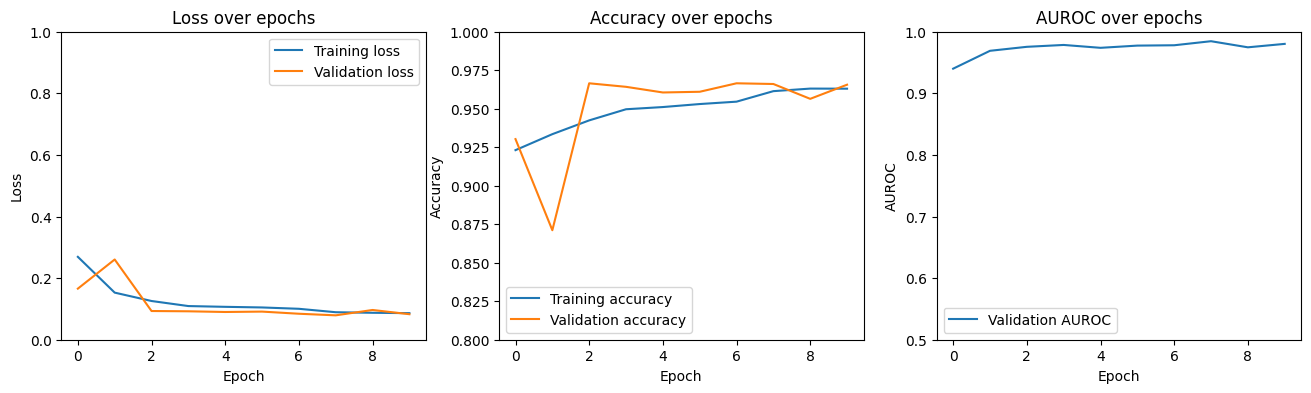

In [53]:
# 손실, 정확도, AUROC 그래프 그리기
plt.figure(figsize=(16, 4))

# 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)  # y축 범위 설정
plt.legend()

# 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # y축 범위 설정
plt.legend()

# AUROC 그래프
plt.subplot(1, 3, 3)
plt.plot(val_aurocs, label='Validation AUROC')
plt.title('AUROC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.ylim(0.5, 1.0)  # y축 범위 설정
plt.legend()

plt.show()

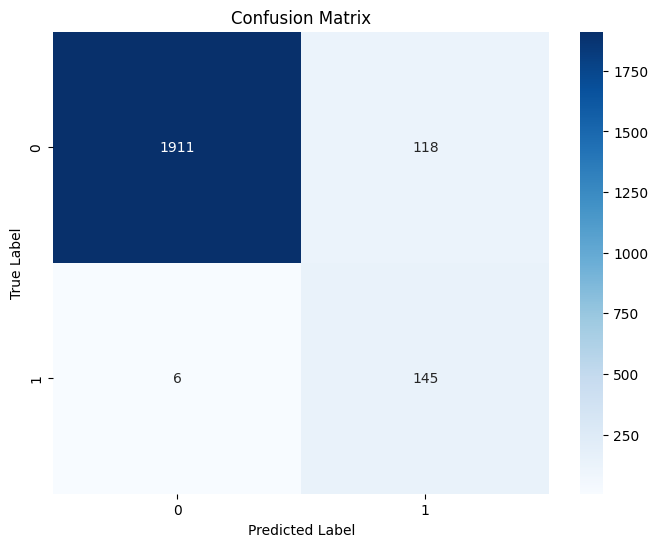

Accuracy: 0.9431
Precision: 0.5513
Recall: 0.9603
F1 Score: 0.7005
Optimal Threshold (Youden Index): 0.04687551


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# 모델을 평가 모드로 설정
model.eval()

# 모든 확률과 레이블을 저장할 리스트 초기화
all_preds_probs = []
all_labels = []

# 테스트 데이터에 대한 예측 수행 (확률만 계산)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).view(-1)  # 시그모이드 함수 적용
        all_preds_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 예측 확률과 실제 레이블을 사용하여 ROC 커브 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_preds_probs)

# Youden의 지수 계산
youden_index = tpr - fpr

# 최대 Youden 지수를 가진 임계값 찾기
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

# 최적 임계값을 사용하여 예측 수행
all_predictions = (np.array(all_preds_probs) > optimal_threshold).astype(int)

# 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 성능 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print("Optimal Threshold (Youden Index):", optimal_threshold)

In [56]:
print(roc_curve(all_labels, all_preds_probs))

(array([0.00000000e+00, 0.00000000e+00, 9.85707245e-04, 9.85707245e-04,
       1.97141449e-03, 1.97141449e-03, 2.46426811e-03, 2.46426811e-03,
       2.95712173e-03, 2.95712173e-03, 3.44997536e-03, 3.44997536e-03,
       3.94282898e-03, 3.94282898e-03, 4.43568260e-03, 4.43568260e-03,
       4.92853622e-03, 4.92853622e-03, 5.42138985e-03, 5.42138985e-03,
       5.91424347e-03, 5.91424347e-03, 6.40709709e-03, 6.40709709e-03,
       6.89995071e-03, 6.89995071e-03, 7.39280434e-03, 7.39280434e-03,
       7.88565796e-03, 7.88565796e-03, 8.87136520e-03, 8.87136520e-03,
       9.36421883e-03, 9.36421883e-03, 9.85707245e-03, 9.85707245e-03,
       1.03499261e-02, 1.03499261e-02, 1.08427797e-02, 1.08427797e-02,
       1.13356333e-02, 1.13356333e-02, 1.23213406e-02, 1.23213406e-02,
       1.33070478e-02, 1.33070478e-02, 1.42927551e-02, 1.42927551e-02,
       1.47856087e-02, 1.47856087e-02, 1.57713159e-02, 1.57713159e-02,
       1.62641695e-02, 1.62641695e-02, 1.67570232e-02, 1.67570232e-02,
     

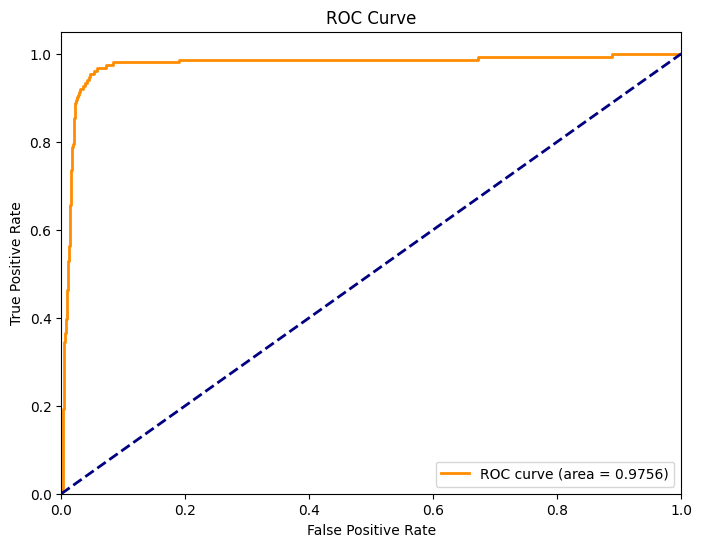

AUROC: 0.9756


In [55]:
# 예측 확률을 저장할 리스트
all_preds_probs = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, _ = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.4f}')
